# Random Forest Low
As part of the overall stacking model, I will develop two Random Forest (RF) models: one with a relative low depth, and one with a high depth. I define low depth as `max_depth = 5` and high depth as `max_depth = 15`. With the depth defined, I tune the remaining parameters sequentially.  
  
In this notebook, I set out to optimise a **low depth RF model**.

In [1]:
# Import modules
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score, auc, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, RobustScaler
import warnings

# Settings
%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Prepare Data

In [9]:
# Import data
df = pd.read_csv('train_clean.csv')

# Data and labels
X = df.drop('Survived', axis = 1)
X = pd.get_dummies(X)
y = df['Survived']

## Global Settings and Functions

In [27]:
# Repeated 5-fold validation
rkf = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=123)

# Function to extract CV test results
def gaia_get_test(cv_object, params, title = 'Test Scores vs. Parameter'):
    
    # Extract test scores
    temp_test = cv_object.cv_results_['mean_test_score']
    
    # Plot
    plt.plot(params, temp_test)
    plt.title(title)
    plt.show()


## Low Depth

### Iteration 1: Optimise No. of Trees
With `max_depth = 5`, the optimal number of trees was 1,000. Although 2,500 trees gave an equally good outcome, it is much more computationally expensive.

In [15]:
# Define parameters
param_n_estimators = [100, 250, 500, 1000, 1500, 2000, 2500, 3000]
params = {
    'n_estimators': param_n_estimators
}

In [16]:
# Create RF model
rf_low = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        oob_score = True,
        random_state = 123
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low.fit(X, y)

Fitting 25 folds for each of 9 candidates, totalling 225 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 225 out of 225 | elapsed:  7.9min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002656BA44F60>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_estimators': [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [17]:
# Print results
print('Best Score: ' + str(np.mean(rf_low.cv_results_['mean_test_score'])))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8310263125077939
Best Params: {'n_estimators': 1000}


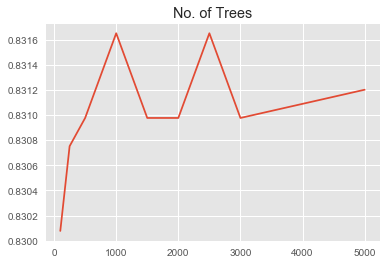

In [28]:
# Plot results
gaia_get_test(rf_low, param_n_estimators, 'No. of Trees')

### Iteration 2: Run RFECV
The accuracy score increased with the number of features supplied. Thus, feature selection did not yield any valuable results. We will not subset the data at this point. If we do choose to, we would choose 17.

In [29]:
# Create model
rf_low2 = RFECV(
    estimator = RandomForestClassifier(random_state=123, max_depth=5, n_estimators=1000, n_jobs = 3),
    cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=5),
    verbose = 2,
    n_jobs = 3
)

# Fit model
rf_low2.fit(X, y)

RFECV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002656C27FAC8>,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
   n_jobs=3, scoring=None, step=1, verbose=2)

In [30]:
# Results of RFE
print('No. of Features: ' + str(rf_low2.n_features_))
print('Feature Ranking:')
rfe_feats = pd.DataFrame(rf_low2.ranking_, columns = ['rank'])
rfe_feats['feature'] = X.columns
rfe_feats.sort_values(by = 'rank')

No. of Features: 53
Feature Ranking:


,rank,feature
0,1,pclass_OC
29,1,sex_OH_male
30,1,age_OH_A1
31,1,age_OH_A2
32,1,age_OH_A3
33,1,sibsp_OH_None
34,1,sibsp_OH_One
35,1,sibsp_OH_Two or More
36,1,parch_OH_None
38,1,parch_OH_Two or More


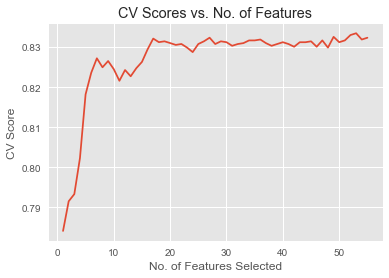

In [31]:
# Plots
plt.figure()
plt.title('CV Scores vs. No. of Features')
plt.xlabel("No. of Features Selected")
plt.ylabel("CV Score")
plt.plot(range(1, len(rf_low2.grid_scores_) + 1), rf_low2.grid_scores_)
plt.show()

In [32]:
rf_low2.grid_scores_

array([0.78411395, 0.79151336, 0.79330486, 0.80228873, 0.81820498,
       0.82359465, 0.82720662, 0.82496185, 0.82652483, 0.82449606,
       0.82159106, 0.82428017, 0.8227147 , 0.82473468, 0.82630145,
       0.82944004, 0.83212788, 0.83123404, 0.83144486, 0.8310068 ,
       0.83054724, 0.83077954, 0.82988571, 0.82875199, 0.83077322,
       0.83144993, 0.83234885, 0.83076566, 0.83144362, 0.8312227 ,
       0.83032508, 0.8307682 , 0.83099417, 0.83166583, 0.83167087,
       0.83189306, 0.8309929 , 0.83031999, 0.83077446, 0.83122391,
       0.83076944, 0.83009277, 0.83121639, 0.83121761, 0.83144615,
       0.83009528, 0.83167336, 0.82987307, 0.8325622 , 0.8312227 ,
       0.83167589, 0.83301162, 0.83345982, 0.83189179, 0.83234124])

### Subset Features
The line below determines how strictly we adhere to the results of RFECV. Rank 1 features are arguably the top-notch ones. However, it is worth experimenting with features in the lower ranks.

In [ ]:
# Subset features
# X_sub = X.iloc[:, (rf_low2.ranking_ == 1)]

### Iteration 3: Optimise Max Features

In [39]:
# Define parameters
param_max_feat = np.arange(2, 40, 1)
params = {
    'max_features': param_max_feat
}

In [41]:
# Create RF model
rf_low3 = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        n_estimators = 1000,
        oob_score = True,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low3.fit(X, y)

Fitting 25 folds for each of 38 candidates, totalling 950 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   44.8s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed:  7.0min
[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed: 12.6min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 19.9min
[Parallel(n_jobs=3)]: Done 950 out of 950 | elapsed: 24.1min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002656C18C5C0>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [42]:
# Print results
print('Best Score: ' + str(np.mean(rf_low3.cv_results_['mean_test_score'])))
print('Best Params: ' + str(rf_low3.best_params_))

Best Score: 0.8278102664067577
Best Params: {'max_features': 6}


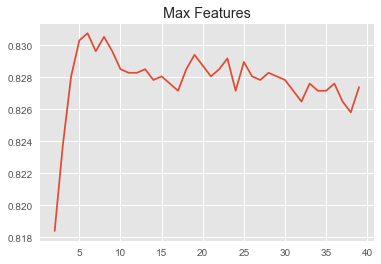

In [43]:
# Plot results
gaia_get_test(rf_low3, param_max_feat, 'Max Features')

### Iteration 4: Optimise Minimum Samples in Terminal Nodes

In [45]:
# Define parameters
param_min_leaf = [1,5,10,20,30,40,50]
params = {
    'min_samples_leaf': param_min_leaf
}

In [47]:
# Create RF model
rf_low4 = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        n_estimators = 1000,
        max_features = 6,
        oob_score = True,
        random_state = 123
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low4.fit(X, y)

Fitting 25 folds for each of 7 candidates, totalling 175 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   22.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 175 out of 175 | elapsed:  3.7min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002656C18C5C0>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'max_features': [1, 5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [51]:
# Print results
print('Best Score: ' + str(np.mean(rf_low4.cv_results_['mean_test_score'])))
print('Best Params: ' + str(rf_low4.best_params_))

Best Score: 0.8280262946929614
Best Params: {'max_features': 10}


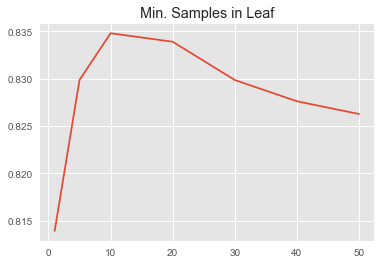

In [53]:
# Plot results
gaia_get_test(rf_low4, param_min_leaf, 'Min. Samples in Leaf')

### Iteration 5: Optimise Criterion

In [54]:
# Define parameters
param_criterion = ['gini', 'entropy']
params = {
    'criterion': param_criterion
}

In [56]:
# Create RF model
rf_low5 = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        n_estimators = 1000,
        max_features = 6,
        min_samples_leaf = 10,
        oob_score = True,
        random_state = 123
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low5.fit(X, y)

Fitting 25 folds for each of 2 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   29.2s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   55.0s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002656C18C5C0>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [57]:
# Print results
print('Best Score: ' + str(np.mean(rf_low5.cv_results_['mean_test_score'])))
print('Best Params: ' + str(rf_low5.best_params_))

Best Score: 0.8239057239057239
Best Params: {'criterion': 'entropy'}


In [77]:
# Print
print('Gini: ' + str(rf_low5.cv_results_['mean_test_score'][0]))
print('Entropy: ' + str(rf_low5.cv_results_['mean_test_score'][1]))

Gini: 0.8235690235690236
Entropy: 0.8242424242424242
: 0.8242424242424242


### Iteration 6: Optimise Minimum Samples for Split

In [80]:
# Define parameters
param_min_split = [10,20,30,40,50,75,100]
params = {
    'min_samples_split': param_min_split
}

In [81]:
# Create RF model
rf_low6 = GridSearchCV(
    estimator = RandomForestClassifier(
        max_depth = 5,
        n_estimators = 1000,
        max_features = 6,
        min_samples_leaf = 10,
        criterion = 'entropy',
        oob_score = True,
        random_state = 123
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 3
)

# Train model
rf_low6.fit(X, y)

Fitting 25 folds for each of 7 candidates, totalling 175 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   28.9s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 175 out of 175 | elapsed:  3.8min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002656C18C5C0>,
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'min_samples_split': [10, 20, 30, 40, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [82]:
# Print results
print('Best Score: ' + str(rf_low6.best_score_))
print('Best Params: ' + str(rf_low6.best_params_))

Best Score: 0.8246913580246914
Best Params: {'min_samples_split': 10}


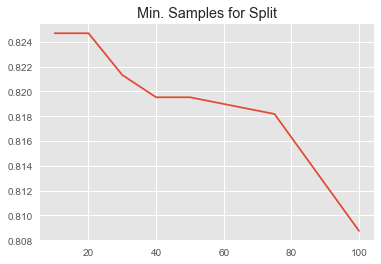

In [83]:
# Plot results
gaia_get_test(rf_low6, param_min_split, 'Min. Samples for Split')

### Iteration 7: Optimise